# Precipitation exercises
***

## <font color=steelblue>Exercise 4 - Areal precipitation: hypsometric method
    
<font color=steelblue>Compute the mean annual areal precipitation in the Pas river catchment (Cantabria) via the hypsometric method. The initial data are the digital elevation model of the catchment (*dem_pas.csv*), and the daily precipitation records for the stations within the catchment (*daily_rainfall_pas.csv*) together with their location (*stations_pas.csv*).</font>

In [1]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('notebook')

The __areal precipitation__ is an aggregate value of precipitation that applies to a catchment. It can be estimated in different ways, one of which is based in the hypsometric curve. In this method, areal precipitation is a weighted mean of the precipitation at several altitude bands in which the catchments is divided.

$$P_{areal} = \sum_z w_z \cdot P_z$$
$$ \sum_z w_z = 1$$

where $P_z$ is the precipitation at each of the elevation bands and $w_z$ are the weights given to each of the bands according to the hypsometric curve.

Following the previous equation, in order to calculate the areal precipitation we must follow these steps:
1. Use the hypsometric curve to calculate the weights for each elevation band.
2. Estimate precipitation for each elevation band.
3. Comput the summation.

### 1. Hypsometric curve
The **hypsometric curve** defines the fraction of the area of a catchment that lies below a given altitude. In this exercise, we'll use the hypsometric curve to assign weights to altitude bands.

The data required to draw the hypsometric curve is the topography of the catchment; in our case, we have its **digital elevation model (DEM)**. The DEM is given in an ASCII format (open *dem_pas.csv* with a text processor), which is a plain text file. The first 6 rows of the text file define the attributes of the map (number of columns, number of rows, coordinate X of the lower left corner, coordinate Y of the lower left corner, size of the cells in the map, and the code given to cells with no value). The following rows are the map itself; they contain the data for a rectangular matrix representing the map.

#### Import DEM
To import the DEM we are using a function called `read_ascii` which is included in the notebook *functions_precipitation.ipynb* given along with the exercises. To import functions from another notebook, we must use the Python magic function `%run`.

In [2]:
# import function to read ASCII maps
%run functions_precipitation.ipynb

In [3]:
# import the DEM
dem, attributes = read_ascii('../data/dem_pas.asc')

In [4]:
# chek the attributes
attributes

[139, 230, 328500.0, 4727155.0, 200, -9999.0]

These are the number of columns and rows, the X and Y coordinate of the lower left corner of the map, the size of a cell, and a code given to cells with no data.

In [5]:
# check what's inside dem
dem

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

We see nothing because all the displayed cells do not belong to the catchment, so they have no data. Let's better plot the map.

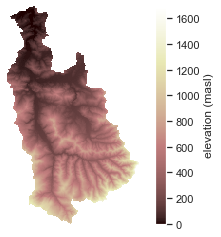

In [6]:
# visualize the DEM
im = plt.imshow(dem, cmap='pink')
cb = plt.colorbar(im)
cb.set_label('elevation (masl)')
plt.axis('off');

In [7]:
# minimum and maximum of the DEM
np.nanmin(dem), np.nanmax(dem)

(0.0, 1694.456)

#### Derive the hypsometric curve
To  derive the hypsometric curve we have to define elevation thresholds and calculate, for each of them, the ratio betweem the area below that threshold and the total area of the catchment. Since all cells have the same area, we will use the number of cells as a measure of area.

In [8]:
# define elevation thresholds
Zs = np.arange(start=0, stop=1701, step=100)
Zs

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700])

In [9]:
# total number of cells in the catchment
ncells = np.sum(~np.isnan(dem))
ncells

16265

__EXAMPLE: 100 m elevation threshold__

In [10]:
# set the threshold
Z = 100

In [11]:
# number of cells below 100 m elevation
n = np.sum(dem < Z)
n

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


2049

In [12]:
# value in the hypsometric curve, i.e., fraction of catchment area below 'Z'
n / ncells

0.1259760221334153

__Loop for all elevation thresholds__

In [13]:
# pandas.Series where to save the data
hypso = pd.Series(index=Zs)

In [14]:
# compute the hypsometric curve
for Z in Zs:
    hypso[Z] = np.sum(dem < Z) / ncells
hypso.head()

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


0      0.000000
100    0.125976
200    0.256871
300    0.370058
400    0.471073
dtype: float64

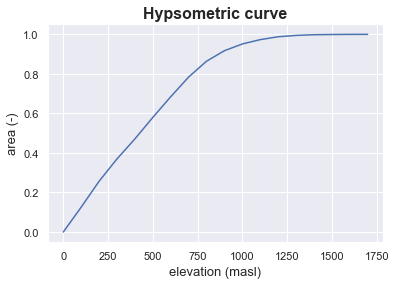

In [15]:
# line plot
plt.plot(Zs, hypso)
plt.title('Hypsometric curve', fontsize=16, weight='bold')
plt.xlabel('elevation (masl)', fontsize=13)
plt.ylabel('area (-)', fontsize=13);

#### Calculate weights
The purpose of deriving the hypsometric curve is to give weights to each of the elevation bands. This weight is the fraction of the catchment area that lies between the two bounds of the elevation band. Using the hypsometric curve, it is the difference between the value of the curve for those two bounds.
$$w_{z} = hypsometric_{z_j} - hypsometric_{z_i}$$
where $z_j$ is the upper bound and $z_i$ is the lower bound of a given elevation band $z$.

In [25]:
np.mean([100, 200])

150.0

In [40]:
del weights

In [43]:
# compute the weight
Zbands = []
weights = []
for Zi, Zj in zip(Zs[:-1], Zs[1:]):
    Zbands.append(np.mean([Zi, Zj]))
    weights.append(hypso[Zj] - hypso[Zi])
weights = pd.Series(data=weights, index=Zbands)
weights 

50.0      0.125976
150.0     0.130895
250.0     0.113188
350.0     0.101014
450.0     0.108823
550.0     0.104396
650.0     0.099662
750.0     0.080172
850.0     0.053120
950.0     0.034184
1050.0    0.021826
1150.0    0.014633
1250.0    0.006702
1350.0    0.003504
1450.0    0.001107
1550.0    0.000615
1650.0    0.000184
dtype: float64

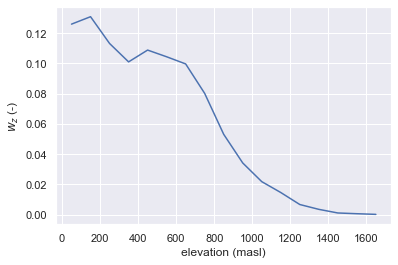

In [55]:
# visualize weights
plt.plot(weights)
plt.xlabel('elevation (masl)')
plt.ylabel('$w_{z}$ (-)');

### 2. Precipitation vs elevation
The input precipitation data our daily records at several pluviometers within the catchment. With this data, we must estimate a value of mean annual precipitation for each elevation band.

1. Estimate the mean annual precipitation at each station from the daily records.
2. Use those estimates to calculate the mean annual precipitation at the elevation bands. To do it, we will use a linear regression between precipitation and elevation.

#### Import data

In [58]:
# Import precipitation data
pcp_d = pd.read_csv('../data/daily_precipitation_Pas.csv', parse_dates=True, index_col=0)
pcp_d.tail()

,1115,1117B,1120,1122I,1127,1127U,1128,1129
fecha,,,,,,,,
2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# import the attributes of the stations
stns = pd.read_csv('../data/stations_pas.csv', index_col='CODE')
stns

,NAME,PROVINCE,X,Y,Z
CODE,,,,,
1115,PUENTE ARCE,CANTABRIA,423820,4806679,13
1117B,VEGA DE PAS G C,CANTABRIA,436607,4778779,390
1120,SEL DE LA CARRERA,CANTABRIA,424623,4777667,537
1122I,ESCOBEDO DE VILLAFUFRE,CANTABRIA,426123,4790918,180
1127,SAN MARTIN DE VILLAFUFRE,CANTABRIA,428593,4789966,300
1127U,SANTA MARIA DE CAYON (G.C.),CANTABRIA,430454,4795500,100
1128,LA PENILLA,CANTABRIA,428436,4796446,140
1129,CASTAÑEDA,CANTABRIA,423030,4796506,121


#### Mean annual precipitation at the stations
From the daily precipitation series we must estimate a value of mean annual precipitation for each station.

__EXAMPLE: station 1115__

In [60]:
stn = '1115'

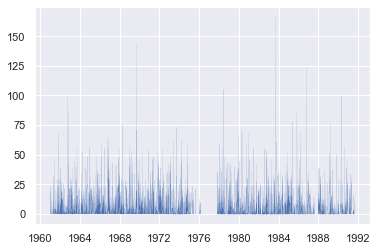

In [63]:
# visualize the data
plt.plot(pcp_d.index, pcp_d[stn], linewidth=.1);

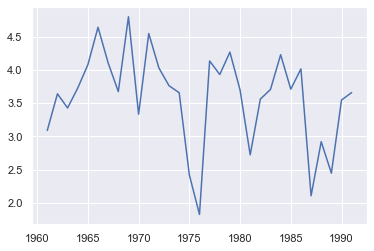

In [64]:
# annual series of mean precipitation
pcp_an = pcp_d[stn].groupby(pcp_d[stn].index.year).mean()
plt.plot(pcp_an);

Some years (e.g. 1975) have a significantly lower value of mean precipitation, probably caused by the lack of data during a good deal of the year. Apart from that, in the previous plot we could observe gaps in the series. For both reasons, we may need to delete some years from the annual series, those with excessive missing data.

We will calculate the number of days with data for each year and plot it.

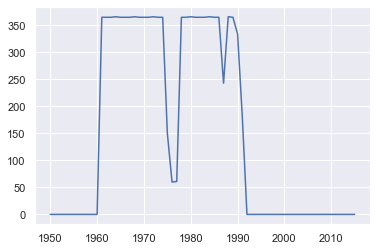

In [73]:
# number of days with data per year
daysYear = pcp_d[stn].groupby(pcp_d[stn].index.year).count()
plt.plot(daysYear);

Now, we set a threshold on the number of days per year, and use only those years with enough data to calculate the mean annual precipitation.

In [74]:
# set a threshold for the minimum number of days per year
thr = 330

In [75]:
# compute the mean annual precipitation for those years above the thresold
pcp_an.loc[daysYear > 330].mean() * 365.25

1365.7634232909663

In [76]:
# what if we hadn't rejected years with poor data?
pcp_an.mean() * 365

1311.1996694259778

#### Loop for all the stations

In [79]:
# annual series of mean precipitation
pcp_an = pcp_d.groupby(pcp_d.index.year).mean()

In [80]:
# number of days with data per year
daysYear = pcp_d.groupby(pcp_d.index.year).count()

In [81]:
# series where to save the mean annual precipitation
Pan = pd.Series(index=stns.index)

In [82]:
# compute mean annual precipitation
for stn in stns.index:
    Pan[stn] = pcp_an.loc[daysYear[stn] > 330, stn].mean() * 365
Pan

CODE
1115     1364.828609
1117B    1727.997346
1120     1591.733451
1122I    1490.998165
1127     1545.122189
1127U    1559.114413
1128     1416.518028
1129     1452.810887
dtype: float64

In [83]:
# add the mean annual precipitation to 'stns'
stns['Pan'] = Pan
stns

,NAME,PROVINCE,X,Y,Z,Pan
CODE,,,,,,
1115,PUENTE ARCE,CANTABRIA,423820,4806679,13,1364.828609
1117B,VEGA DE PAS G C,CANTABRIA,436607,4778779,390,1727.997346
1120,SEL DE LA CARRERA,CANTABRIA,424623,4777667,537,1591.733451
1122I,ESCOBEDO DE VILLAFUFRE,CANTABRIA,426123,4790918,180,1490.998165
1127,SAN MARTIN DE VILLAFUFRE,CANTABRIA,428593,4789966,300,1545.122189
1127U,SANTA MARIA DE CAYON (G.C.),CANTABRIA,430454,4795500,100,1559.114413
1128,LA PENILLA,CANTABRIA,428436,4796446,140,1416.518028
1129,CASTAÑEDA,CANTABRIA,423030,4796506,121,1452.810887


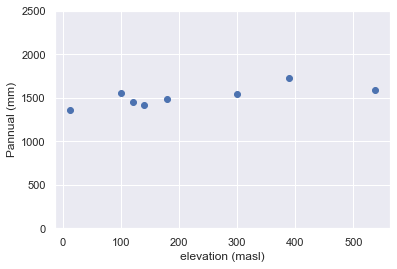

In [87]:
# visualize data
plt.scatter(stns.Z, stns.Pan)
plt.xlabel('elevation (masl)')
plt.ylabel('Pannual (mm)')
plt.ylim(0, 2500);

#### Linear regression
The linear regression follows the equation:

$$P_{an} = m·Z+n$$

Where $_{an}$ is mean annual precipitation (mm) at a point with altitude $Z$ (m.a.s.l), and $m$ and $n$ are the slope and intercept of the regressed line, respectively.

We will use the function `linregress` in `scipy.stats` to perform the linear regressión between elevation ($Z$) and mean anual precipitation ($P_{an}$). This function provides us both with the two coefficientes of the linear regression and some performance metrics.

In [88]:
# import the function
from scipy.stats import linregress

In [89]:
# fit the linear regression
m, n, *perf = linregress(stns.Z, stns.Pan)
print('P = {0:.3f} Z + {1:.3f}'.format(m, n))

P = 0.492 Z + 1409.163


In [90]:
# check performance
print('R = {0:.3f}\np-value = {1:.3f}\nstd-error = {2:.3f}'.format(*perf))

R = 0.750
p-value = 0.032
std-error = 0.177


Where $R$ is the Pearsons's correlation coefficient, $p_{value}$ is a metric of the confidence that the regression is statistically significant (if $p_{value} \leq 0.05$), and $std-error$ is the standard error.

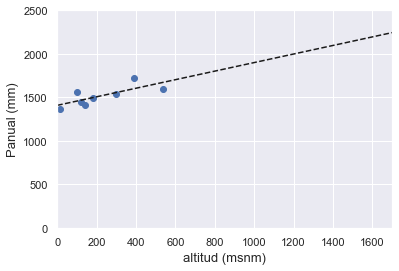

In [92]:
# plot the regression between elevation and annual precipitation
plt.scatter(stns.Z, stns.Pan)
# recta de regresión
xlim = np.array([Zs.min(), Zs.max()])
plt.plot(xlim, m * xlim + n, 'k--')
# configuración
plt.xlabel('altitud (msnm)', fontsize=13)
plt.xlim(xlim)
plt.ylabel('Panual (mm)', fontsize=13)
plt.ylim(0, 2500);

# guardar la figura
plt.savefig('../output/Ex4_linear regression Z-Pannual.png', dpi=300)

As in this case, it is usual that the meteorological stations are located in lower areas of the catchment, basically for accessibility reasons. Therefore, the importance of this linear regression to estimate the precipitation at the higher areas of the cathcment. Otherwise, we would underestimate areal precipitation.

#### Estimate precipitation for each elevation band
We have fitted the linear regression with the intention of interpolating mean annual precipitation for each of the elevation bands in the hypsometric curve.

In [100]:
# interpolate mean annual precipitation for each band
Zbands = np.array(Zbands)
Pz = m * Zbands + n
Pz = pd.Series(data=Pz, index=Zbands)
Pz

50.0      1433.750805
150.0     1482.926522
250.0     1532.102238
350.0     1581.277955
450.0     1630.453672
550.0     1679.629389
650.0     1728.805106
750.0     1777.980823
850.0     1827.156540
950.0     1876.332257
1050.0    1925.507973
1150.0    1974.683690
1250.0    2023.859407
1350.0    2073.035124
1450.0    2122.210841
1550.0    2171.386558
1650.0    2220.562275
dtype: float64

### 3. Areal precipitation
Once we have computed the weights (_weights_) and the mean annual precipitation (_Pz_) for each elevation band, the areal precipitation is the summation of the product of those two series.

In [101]:
Pareal = np.sum(weights * Pz)

print('The mean annual precipitation in the catchment is {0:.1f} mm'.format(Pareal))

The mean annual precipitation in the catchment is 1632.5 mm


If we had calculated the areal precipitation by the station-average method (see exercise 1), we would've underestimated the areal precipitation in the catchment. The reason is the fact that most of the stations are located in lower areas.

In [103]:
Pareal2 = stns.Pan.mean()

print('The mean annual precipitation in the catchment is {0:.1f} mm'.format(Pareal2))

The mean annual precipitation in the catchment is 1518.6 mm
